In [ ]:
#AI Trainer for the Adjustments Project


In [16]:
#Load input data
import pandas as pd
import numpy as np

#Load data
df=pd.read_csv('SampleData.csv')
df.head(10)

,AdjustmentType,AdjustmentName,AdjustedField,Drawn,Undrawn,PD,CustomerID,CustomerType,RiskCategory,IsDefaulted,CountryCode,NewVal
0,Amend,Defaulting Cleanup,CustomerType,320556,926432,0.51,CUST712035,Retail,High,1,DE,Debt Recovery
1,Amend,GRC_EndMonth,RiskCategory,445673,250506,0.09,CUST103289,Retail,Low,0,DE,Low
2,Amend,Fix_Broken_Batch,IsDefaulted,497711,485580,0.77,CUST804231,Retail,Medium,0,GB,0
3,Amend,Credit_Uplift,CountryCode,864787,124640,0.36,CUST981372,Corporate,Medium,0,US,US
4,Amend,GRC_EndMonth,RiskCategory,16181,216632,0.47,CUST981372,SME,Medium,1,US,Medium
5,Amend,GRC_EndMonth,CustomerID,407088,151484,0.61,CUST238947,Retail,Low,1,DE,CUST103289
6,Amend,Default,CountryCode,620801,887390,0.50,CUST563201,SME,High,0,DE,DE
7,Amend,GRC_EndMonth,IsDefaulted,308468,13027,0.01,CUST238947,Retail,Medium,0,DE,0
8,Amend,Default,IsDefaulted,307462,986828,0.89,CUST359147,SME,Medium,0,GB,1
9,Amend,Credit_Uplift,CountryCode,848961,198589,0.76,CUST238947,Corporate,Low,0,GB,US


In [18]:
#Stage 1: OneHot encode string inputs and labels so we can use them in the model

#Build list of all string columns in the dataframe
string_columns=[]
for col in df.columns:
    if df[col].dtype=='object':
        string_columns.append(col)

#Turn output labels into numbers
outputLabels=df["NewVal"].unique()
# #Create a dictionary to map the output labels to numbers
outputLabelsDict={}
for i in range(len(outputLabels)):
    outputLabelsDict[outputLabels[i]]=i
df["NewVal"]=df["NewVal"].map(outputLabelsDict)

df_encoded=pd.get_dummies(df, columns=string_columns)

#Move NewVal to the end of the dataframe
df_encoded=df_encoded[[c for c in df_encoded if c not in ['NewVal']] + ['NewVal']]

df_encoded


,Drawn,Undrawn,PD,IsDefaulted,AdjustmentType_Amend,AdjustmentName_Credit_Uplift,AdjustmentName_Default,AdjustmentName_Defaulting Cleanup,AdjustmentName_Defaulting_Reclassify,AdjustmentName_Fix_Broken_Batch,...,CustomerType_Corporate,CustomerType_Retail,CustomerType_SME,RiskCategory_High,RiskCategory_Low,RiskCategory_Medium,CountryCode_DE,CountryCode_GB,CountryCode_US,NewVal
0,320556,926432,0.51,1,1,0,0,1,0,0,...,0,1,0,1,0,0,1,0,0,0
1,445673,250506,0.09,0,1,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,1
2,497711,485580,0.77,0,1,0,0,0,0,1,...,0,1,0,0,0,1,0,1,0,2
3,864787,124640,0.36,0,1,1,0,0,0,0,...,1,0,0,0,0,1,0,0,1,3
4,16181,216632,0.47,1,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,811120,101164,0.77,1,1,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,9
996,857021,297219,0.71,0,1,0,1,0,0,0,...,0,0,1,1,0,0,0,0,1,17
997,826499,502939,0.16,1,1,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,9
998,265478,702747,0.05,0,1,1,0,0,0,0,...,1,0,0,0,1,0,0,1,0,14


In [19]:
#Detach the NewVal column and onehot encode it!
labelF=df_encoded["NewVal"]
df_encoded=df_encoded.drop(columns=["NewVal"])

labelF=pd.get_dummies(labelF)
labelF

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [20]:
#Stage 2: Normalize all numeric values
#Normalize the dataframe

#Normalize Drawn (-1 to 1)
df_normalized=df_encoded.copy()
df_normalized["Drawn"]=(df_encoded["Drawn"]-df_encoded["Drawn"].min())/(df_encoded["Drawn"].max()-df_encoded["Drawn"].min())*2-1
#Normalize Undrawn (-1 to 1)
df_normalized["Undrawn"]=(df_encoded["Undrawn"]-df_encoded["Undrawn"].min())/(df_encoded["Undrawn"].max()-df_encoded["Undrawn"].min())*2-1

#Clip PD to 0-1
df_normalized["PD"]=df_normalized["PD"].clip(0,1)


df_normalized

,Drawn,Undrawn,PD,IsDefaulted,AdjustmentType_Amend,AdjustmentName_Credit_Uplift,AdjustmentName_Default,AdjustmentName_Defaulting Cleanup,AdjustmentName_Defaulting_Reclassify,AdjustmentName_Fix_Broken_Batch,...,CustomerID_CUST981372,CustomerType_Corporate,CustomerType_Retail,CustomerType_SME,RiskCategory_High,RiskCategory_Low,RiskCategory_Medium,CountryCode_DE,CountryCode_GB,CountryCode_US
0,-0.358693,0.852688,0.51,1,1,0,0,1,0,0,...,0,0,1,0,1,0,0,1,0,0
1,-0.108171,-0.501833,0.09,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
2,-0.003976,-0.030757,0.77,0,1,0,0,0,0,1,...,0,0,1,0,0,0,1,0,1,0
3,0.731021,-0.754062,0.36,0,1,1,0,0,0,0,...,1,1,0,0,0,0,1,0,0,1
4,-0.968143,-0.569714,0.47,1,1,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.623563,-0.801106,0.77,1,1,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
996,0.715471,-0.408222,0.71,0,1,0,1,0,0,0,...,0,0,0,1,1,0,0,0,0,1
997,0.654357,0.004030,0.16,1,1,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
998,-0.468976,0.404435,0.05,0,1,1,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0


In [21]:
print(len(df_normalized))
print(len(labelF))

1000
1000


In [23]:
#Turn the pandas dataframe into a numpy array, split out the label and then break into sets
import tensorflow as tf

#turn df_normalized into a normal array
data=df_normalized.values

#Get all columns except the output column
X=data[:,1:]

#Get the output column
data=labelF.values
y=data[:,:]


from sklearn.model_selection import train_test_split
#split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)




In [24]:
print(len(X))
print(len(y))

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))


1000
1000
800
200
800
200


In [51]:
#Time to build the model

#Simple feed-forward model. No U-nets or anything fancy
ann = tf.keras.models.Sequential()

neurons=1000
num_classes=23

#Input and first hidden layer
ann.add(tf.keras.layers.Dense(units=neurons, activation='relu'))
ann.add(tf.keras.layers.Dense(units=neurons, activation='relu'))
ann.add(tf.keras.layers.Dense(units=neurons, activation='relu'))

#Output layer
#Classifier head
ann.add(tf.keras.layers.Dense(units=num_classes, activation='sigmoid'))
# ann.add(tf.keras.layers.Flatten())
# ann.add(tf.keras.layers.Dense(num_classes, activation='softmax'))


#Compile!
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

ann.build(input_shape=(None, X_train.shape[1]))
ann.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 1000)              37000     
                                                                 
 dense_29 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_30 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_31 (Dense)            (None, 23)                23023     
                                                                 
Total params: 2,062,023
Trainable params: 2,062,023
Non-trainable params: 0
_________________________________________________________________


In [52]:
#Train the MODEL!!!!!


#y_test = np.asarray(test_labels).astype('float32').reshape((-1,1))


ann.fit(X_train, y_train, batch_size = 32, epochs = 20)

Epoch 1/25
25/25 [==============================] - 1s 16ms/step - loss: 0.2419 - accuracy: 0.2225
Epoch 2/25
25/25 [==============================] - 0s 16ms/step - loss: 0.1177 - accuracy: 0.4175
Epoch 3/25
25/25 [==============================] - 0s 16ms/step - loss: 0.0804 - accuracy: 0.4950
Epoch 4/25
25/25 [==============================] - 0s 16ms/step - loss: 0.0759 - accuracy: 0.5138
Epoch 5/25
25/25 [==============================] - 0s 16ms/step - loss: 0.0722 - accuracy: 0.5638
Epoch 6/25
25/25 [==============================] - 0s 16ms/step - loss: 0.0663 - accuracy: 0.5900
Epoch 7/25
25/25 [==============================] - 0s 16ms/step - loss: 0.0625 - accuracy: 0.6400
Epoch 8/25
25/25 [==============================] - 0s 16ms/step - loss: 0.0599 - accuracy: 0.6725
Epoch 9/25
25/25 [==============================] - 0s 16ms/step - loss: 0.0550 - accuracy: 0.7075
Epoch 10/25
25/25 [==============================] - 0s 16ms/step - loss: 0.0521 - accuracy: 0.7225
Epoch 11/

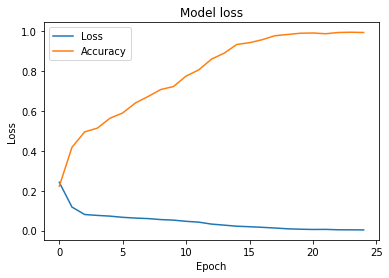

In [53]:
#Plot the loss and accuracy
import matplotlib.pyplot as plt

plt.plot(ann.history.history['loss'])
plt.plot(ann.history.history['accuracy'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Accuracy'], loc='upper left')
plt.show()



In [54]:
#Validate the model against the test set
y_pred = ann.predict(X_test)
y_pred = (y_pred > 0.5)

#Get the accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)


7/7 [==============================] - 0s 3ms/step


0.44